In [2]:
from random import random
from matplotlib import pyplot as plt
import numpy as np

def symbol_modulate(QPSK_symbol):
    # Constellation
    # 00 -> A * exp( j * pi / 4)  = 1 + j
    # 01 -> A * exp( j * 3pi / 4) = -1 + j
    # 11 -> A * exp(-j * 3pi / 4) = -1 - j
    # 10 -> A * exp(-j * pi / 4) = 1 - j

    I_sign = 0
    Q_sign = 0

    if QPSK_symbol[0] == 0:
        Q_sign = 1
    else:
        Q_sign = -1

    if QPSK_symbol[1] == 0:
        I_sign = 1
    else:
        I_sign = -1

    return I_sign, Q_sign

def symbol_demodulate(QPSK_signal):
    # See the constellation in modulation.
    I_data = 0
    Q_data = 0

    if QPSK_signal.real > 0:
        Q_data = 0
    else:
        Q_data = 1

    if QPSK_signal.imag > 0:
        I_data = 0
    else:
        I_data = 1

    return I_data, Q_data


In [3]:
Fs = 8000
carrier_frequency = 200
data_size = 10
samples = Fs / carrier_frequency * data_size / 2
samples_per_symbol = Fs / carrier_frequency


In [22]:
# Data generation
data = np.arange(data_size)
for n in range(0, data_size):
    if random() > 0.5:
        data[n] = 1
    else:
        data[n] = 0

print data

[0 1 0 1 0 1 0 0 0 0]


In [23]:
# Split data into I/Q
I_data = np.arange(data_size / 2)
Q_data = np.arange(data_size / 2)


for n in range(0, data_size, 2):
    I_data[n / 2] = data[n]
for n in range(1, data_size, 2):
    Q_data[n / 2] = data[n]

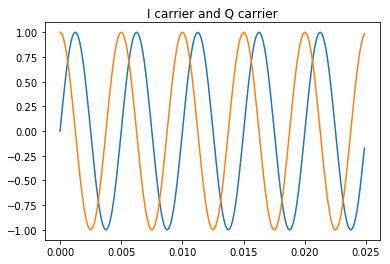

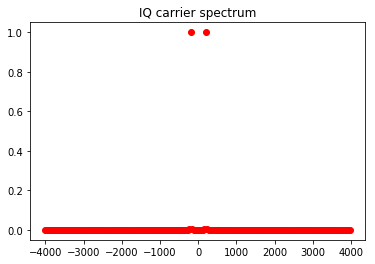

In [28]:
# Generate I/Q carrier
t = np.arange(start = 0, stop = samples * 0.000125, step = 0.000125)
#print t

I_carrier = np.sin(2 * 3.14 * carrier_frequency * t)
Q_carrier = np.cos(2 * 3.14 * carrier_frequency * t)

plt.figure(1)
plt.plot(t, I_carrier, t, Q_carrier)
plt.title('I carrier and Q carrier')
plt.draw()

I_spectrum = np.fft.fft(I_carrier)
Q_spectrum = np.fft.fft(Q_carrier)
freq = np.fft.fftfreq(t.shape[-1], d = 0.000125)

#print freq

plt.figure(2)
plt.plot(freq, np.absolute(I_spectrum) / (samples / 2), 'ro', freq, np.absolute(Q_spectrum) / (samples / 2), 'bo')
plt.title('IQ carrier spectrum')
plt.draw()

I demodulated: [1 0 1 1 1] actual data: [1 0 1 1 1]
Q demodulated: [0 0 1 0 0] actual data: [0 0 1 0 0]


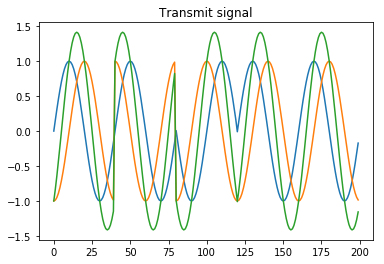

In [18]:
# Modulate carrier with I/Q data
I_modulated = np.arange(samples, dtype=np.float_)
Q_modulated = np.arange(samples, dtype=np.float_)

for n in range(data_size / 2):
    I_sign, Q_sign = symbol_modulate(data[n * 2:n * 2 + 2])
    start = n * samples_per_symbol
    end = (n + 1) * samples_per_symbol

    I_modulated[start: end] = I_sign * I_carrier[start: end]
    Q_modulated[start: end] = Q_sign * Q_carrier[start: end]


# Add the I/Q data in time domain
transmit_signal = I_modulated + Q_modulated
plt.figure(3)
plt.plot(np.arange(samples), I_modulated, np.arange(samples), Q_modulated, np.arange(samples), transmit_signal)
plt.title('Transmit signal')
plt.draw()

# Send signal
receive_signal = transmit_signal

# Separate I/Q data and demodulate
I_demodulated = np.arange(len(I_data))
Q_demodulated = np.arange(len(Q_data))

for n in range(len(I_data)):
    start = n * samples_per_symbol
    end = (n + 1) * samples_per_symbol

    I_integral = np.sum(receive_signal[start: end] * I_carrier[start: end])
    Q_integral = np.sum(receive_signal[start: end] * Q_carrier[start: end])

    I_demodulated[n], Q_demodulated[n] = symbol_demodulate(np.complex(I_integral, Q_integral))


print "I demodulated:", I_demodulated, "actual data:", I_data
print "Q demodulated:", Q_demodulated, "actual data:", Q_data

plt.show()